# Provincial Healthcare Efficiency Rankings (v2)

**Research Question**: Which Canadian provinces deliver the most efficient healthcare, and how should we classify them?

**Improvements over v1**:
- Data-driven K-means clustering replaces arbitrary tier thresholds
- Silhouette analysis validates cluster count
- Uses updated master dataset with volume-weighted wait times, real population, and CAGR physician estimates

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv("../data/final/healthcare_efficiency_master.csv")
print(f"Loaded {len(df)} records: {df['province'].nunique()} provinces, {df['year'].min()}-{df['year'].max()}")

Loaded 169 records: 10 provinces, 2008-2024


## 1. Provincial Efficiency Rankings

In [2]:
# Provincial averages across all years
provincial_stats = df.groupby('province').agg({
    'raw_efficiency': 'mean',
    'avg_wait_time': 'mean',
    'total_spending_per_capita': 'mean'
}).round(1)

best_efficiency = provincial_stats['raw_efficiency'].max()
provincial_stats['efficiency_gap'] = best_efficiency - provincial_stats['raw_efficiency']
provincial_stats['rank'] = provincial_stats['raw_efficiency'].rank(ascending=False).astype(int)

rankings_table = provincial_stats.sort_values('rank')[['rank', 'raw_efficiency', 'avg_wait_time', 'total_spending_per_capita', 'efficiency_gap']]
rankings_table.columns = ['Rank', 'Efficiency_Score', 'Wait_Time_Days', 'Spending_Per_Capita', 'Efficiency_Gap']

print("Provincial Healthcare Efficiency Rankings:")
rankings_table

Provincial Healthcare Efficiency Rankings:


,Rank,Efficiency_Score,Wait_Time_Days,Spending_Per_Capita,Efficiency_Gap
province,,,,,
Ontario,1,299.1,22.5,6719.4,0.0
Nova Scotia,2,174.2,44.9,7547.0,124.9
Saskatchewan,2,174.2,51.7,7505.1,124.9
Prince Edward Island,4,167.2,43.3,7049.2,131.9
Alberta,5,164.2,48.1,7517.4,134.9
Newfoundland and Labrador,6,156.2,70.6,8114.9,142.9
British Columbia,7,144.6,50.7,6793.0,154.5
Manitoba,8,136.6,57.3,7338.0,162.5
Quebec,9,122.7,55.7,6574.9,176.4


## 2. Data-Driven Tier Classification (K-Means)

Instead of arbitrary thresholds, we use K-means clustering on three dimensions:
- Efficiency score
- Average wait time
- Spending per capita

Features are standardized so no single dimension dominates due to scale differences.

k=2: silhouette=0.536, inertia=14.5
k=3: silhouette=0.303, inertia=7.6
k=4: silhouette=0.351, inertia=3.2
k=5: silhouette=0.264, inertia=2.1

Best k by silhouette score: 2


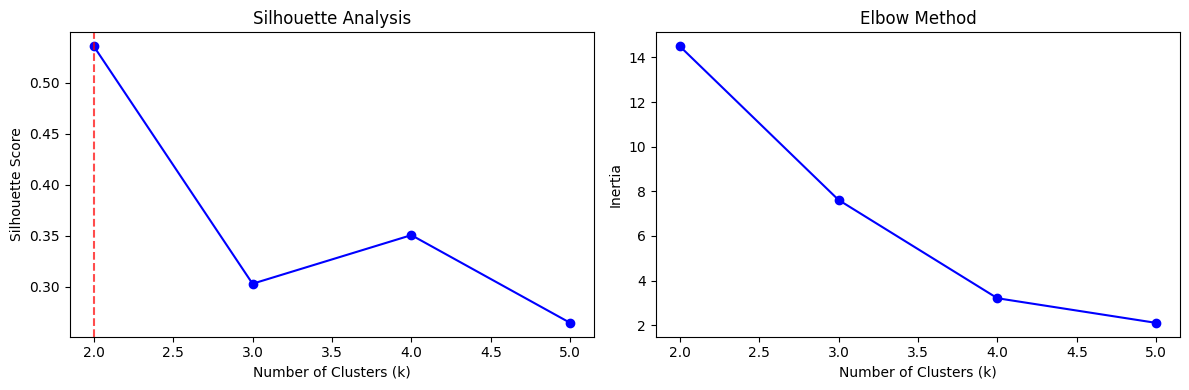

In [3]:
# Prepare features for clustering
cluster_features = provincial_stats[['raw_efficiency', 'avg_wait_time', 'total_spending_per_capita']].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_features)

# Silhouette analysis for k=2 to k=5
k_range = range(2, 6)
silhouette_scores = []
inertias = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil)
    inertias.append(km.inertia_)
    print(f"k={k}: silhouette={sil:.3f}, inertia={km.inertia_:.1f}")

best_k = list(k_range)[np.argmax(silhouette_scores)]
print(f"\nBest k by silhouette score: {best_k}")

# Plot silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(k_range, silhouette_scores, 'bo-')
ax1.axvline(x=best_k, color='red', linestyle='--', alpha=0.7)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Analysis')

ax2.plot(k_range, inertias, 'bo-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Inertia')
ax2.set_title('Elbow Method')
plt.tight_layout()
plt.show()

In [4]:
# Fit K-means with k=3 (or best_k if different)
k = 3
km = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = km.fit_predict(X_scaled)

# Map cluster numbers to tier names based on mean efficiency
cluster_features['cluster'] = cluster_labels
cluster_means = cluster_features.groupby('cluster')['raw_efficiency'].mean().sort_values(ascending=False)
tier_names = {cluster_means.index[0]: 'High', cluster_means.index[1]: 'Medium', cluster_means.index[2]: 'Low'}
cluster_features['kmeans_tier'] = cluster_features['cluster'].map(tier_names)

rankings_table['KMeans_Tier'] = cluster_features['kmeans_tier']

# Compare with old arbitrary tiers
def old_tier(gap):
    if gap <= 25: return 'High'
    elif gap <= 60: return 'Medium'
    else: return 'Low'

rankings_table['Old_Arbitrary_Tier'] = rankings_table['Efficiency_Gap'].apply(old_tier)

print("Tier Comparison — Old Arbitrary vs K-Means:")
rankings_table[['Rank', 'Efficiency_Score', 'Wait_Time_Days', 'Old_Arbitrary_Tier', 'KMeans_Tier']]

Tier Comparison — Old Arbitrary vs K-Means:


,Rank,Efficiency_Score,Wait_Time_Days,Old_Arbitrary_Tier,KMeans_Tier
province,,,,,
Ontario,1,299.1,22.5,High,High
Nova Scotia,2,174.2,44.9,Low,Medium
Saskatchewan,2,174.2,51.7,Low,Medium
Prince Edward Island,4,167.2,43.3,Low,Low
Alberta,5,164.2,48.1,Low,Medium
Newfoundland and Labrador,6,156.2,70.6,Low,Medium
British Columbia,7,144.6,50.7,Low,Low
Manitoba,8,136.6,57.3,Low,Medium
Quebec,9,122.7,55.7,Low,Low


In [5]:
# K-means tier summary
tier_summary = rankings_table.groupby('KMeans_Tier').agg({
    'Efficiency_Score': ['count', 'mean'],
    'Efficiency_Gap': 'mean',
    'Wait_Time_Days': 'mean',
    'Spending_Per_Capita': 'mean'
}).round(1)
tier_summary.columns = ['Province_Count', 'Avg_Efficiency', 'Avg_Gap', 'Avg_Wait_Time', 'Avg_Spending']

print("K-Means Tier Summary:")
tier_summary

K-Means Tier Summary:


,Province_Count,Avg_Efficiency,Avg_Gap,Avg_Wait_Time,Avg_Spending
KMeans_Tier,,,,,
High,1,299.1,0.0,22.5,6719.4
Low,4,137.0,162.1,53.4,6841.7
Medium,5,161.1,138.0,54.5,7604.5


## 3. Statistical Validation

Carried forward from v1 — ANOVA and Pearson correlations are statistically sound.

In [6]:
# ANOVA: are provincial efficiency differences statistically significant?
provinces = df['province'].unique()
efficiency_groups = [df[df['province'] == prov]['raw_efficiency'].dropna().values for prov in provinces]
f_stat, p_anova = stats.f_oneway(*efficiency_groups)

# Pearson correlations
mask = df['raw_efficiency'].notna() & df['avg_wait_time'].notna()
eff_wait_corr, p_wait = stats.pearsonr(df.loc[mask, 'raw_efficiency'], df.loc[mask, 'avg_wait_time'])

mask2 = df['raw_efficiency'].notna() & df['total_spending_per_capita'].notna()
eff_spend_corr, p_spend = stats.pearsonr(df.loc[mask2, 'raw_efficiency'], df.loc[mask2, 'total_spending_per_capita'])

stats_results = pd.DataFrame({
    'Test': ['Provincial Differences (ANOVA)', 'Efficiency vs Wait Time', 'Efficiency vs Spending'],
    'Statistic': [f'F={f_stat:.3f}', f'r={eff_wait_corr:.3f}', f'r={eff_spend_corr:.3f}'],
    'P_Value': [f'{p_anova:.2e}', f'{p_wait:.2e}', f'{p_spend:.2e}'],
    'Significant': [p_anova < 0.05, p_wait < 0.05, p_spend < 0.05]
})

print("Statistical Validation Results:")
stats_results

Statistical Validation Results:


,Test,Statistic,P_Value,Significant
0,Provincial Differences (ANOVA),F=12.750,3.75e-15,True
1,Efficiency vs Wait Time,r=-0.742,9.31e-31,True
2,Efficiency vs Spending,r=0.121,1.17e-01,False


## 4. Visualizations

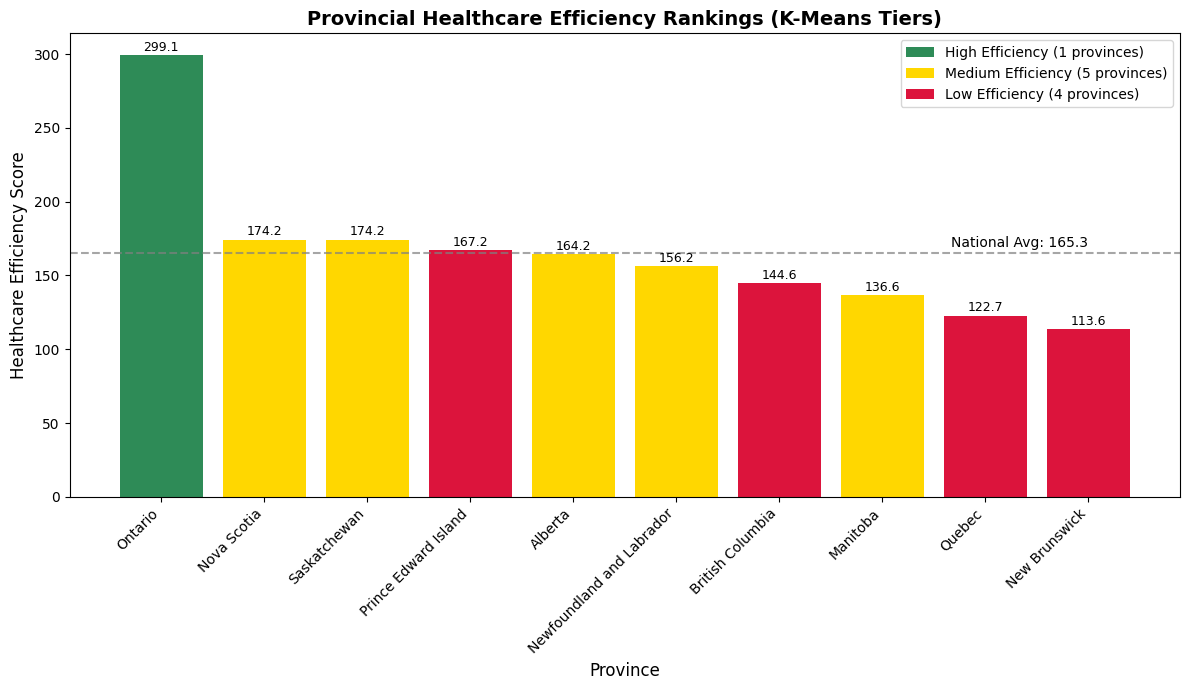

In [7]:
# Efficiency rankings bar chart with K-means tier colors
color_map = {'High': '#2E8B57', 'Medium': '#FFD700', 'Low': '#DC143C'}
colors = [color_map[t] for t in rankings_table['KMeans_Tier']]

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(range(len(rankings_table)), rankings_table['Efficiency_Score'], color=colors)

ax.set_xlabel('Province', fontsize=12)
ax.set_ylabel('Healthcare Efficiency Score', fontsize=12)
ax.set_title('Provincial Healthcare Efficiency Rankings (K-Means Tiers)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(rankings_table)))
ax.set_xticklabels(rankings_table.index, rotation=45, ha='right')

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}', ha='center', va='bottom', fontsize=9)

national_avg = rankings_table['Efficiency_Score'].mean()
ax.axhline(y=national_avg, color='gray', linestyle='--', alpha=0.7)
ax.text(len(rankings_table)-1, national_avg+2, f'National Avg: {national_avg:.1f}',
        ha='right', va='bottom', fontsize=10)

from matplotlib.patches import Patch
tier_counts = rankings_table['KMeans_Tier'].value_counts()
legend_elements = [
    Patch(facecolor='#2E8B57', label=f'High Efficiency ({tier_counts.get("High", 0)} provinces)'),
    Patch(facecolor='#FFD700', label=f'Medium Efficiency ({tier_counts.get("Medium", 0)} provinces)'),
    Patch(facecolor='#DC143C', label=f'Low Efficiency ({tier_counts.get("Low", 0)} provinces)')
]
ax.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

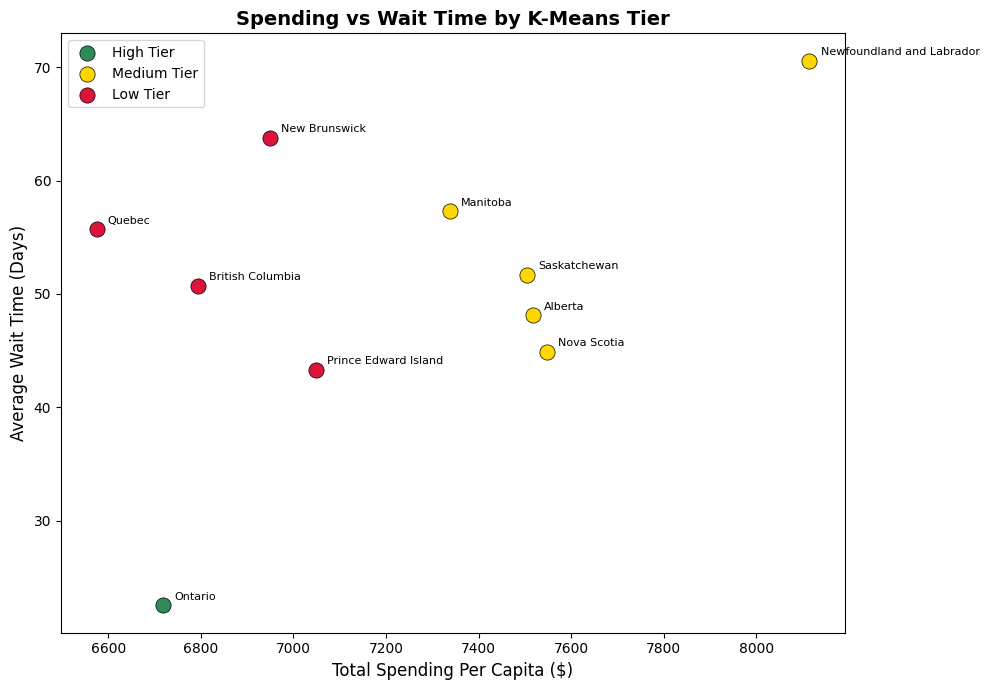

In [8]:
# Scatter: Spending vs Wait Time, colored by K-means tier
fig, ax = plt.subplots(figsize=(10, 7))

for tier, color in color_map.items():
    mask = rankings_table['KMeans_Tier'] == tier
    provs = rankings_table[mask].index
    ax.scatter(
        rankings_table.loc[provs, 'Spending_Per_Capita'],
        rankings_table.loc[provs, 'Wait_Time_Days'],
        c=color, s=120, label=f'{tier} Tier', edgecolors='black', linewidth=0.5, zorder=3
    )
    for prov in provs:
        ax.annotate(prov, (rankings_table.loc[prov, 'Spending_Per_Capita'],
                           rankings_table.loc[prov, 'Wait_Time_Days']),
                    textcoords='offset points', xytext=(8, 4), fontsize=8)

ax.set_xlabel('Total Spending Per Capita ($)', fontsize=12)
ax.set_ylabel('Average Wait Time (Days)', fontsize=12)
ax.set_title('Spending vs Wait Time by K-Means Tier', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()